### ~ 40 mins

In [1]:
#default_exp dicom2tensor

### read -> interpolate/resample -> crop-pad -> save (Requires pydicom=> 1.4.0)

In [2]:
#export
from fastai2.medical.imaging_roi import *
from fastai2.medical.imaging import dicom_windows
from fastai2 import *
from fastai2.torch_core import *
from fastai2.core import *
from fastai2.basics import *

In [3]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 20

In [4]:
data_paths = types.SimpleNamespace(
    ATLAS_PATH = Path("/data/public/PICARE_BMETS_Raw_DICOM_Files"),
    MR_PATH = Path("/data/public/PICARE_SEGMENTATION_BRAINVENT_MR_V1"),
    CT_PATH = Path("/data/public/Training_CT_Raw_DICOM_Files"),
    MR_TEST2_PATH = Path("/data/public/Testing_MR_Raw_DICOM_Files"),
    CT_TEST2_PATH= Path("/data/public/Testing_CT_Raw_DICOM_Files"),
)

In [5]:
data_paths.__dict__

{'ATLAS_PATH': PosixPath('/data/public/PICARE_BMETS_Raw_DICOM_Files'),
 'MR_PATH': PosixPath('/data/public/PICARE_SEGMENTATION_BRAINVENT_MR_V1'),
 'CT_PATH': PosixPath('/data/public/Training_CT_Raw_DICOM_Files'),
 'MR_TEST2_PATH': PosixPath('/data/public/Testing_MR_Raw_DICOM_Files'),
 'CT_TEST2_PATH': PosixPath('/data/public/Testing_CT_Raw_DICOM_Files')}

### create metadata

In [6]:
from fastai2.medical.imaging import DcmDataset, DcmMultiValue, _split_elem, _dcm2dict
def _cast_dicom_special(x):
    cls = type(x)
    if not cls.__module__.startswith('pydicom'): return x
    if cls.__base__ == object: return str(x)
    return cls.__base__(x)
@patch
def as_dict2(self:DcmDataset, px_summ=True, multival=False):
    pxdata = (0x7fe0,0x0010)
    vals = [self[o] for o in self.keys() if o != pxdata]
    its = [(v.keyword,v.value) for v in vals if not (not multival and isinstance(v.value,DcmMultiValue))]
    res = dict(its)
    res['fname'] = self.filename
    for k,v in its: _split_elem(res,k,v)
    for k in res: res[k] = _cast_dicom_special(res[k])
    return res
def _dcm2dict2(o): return o.dcmread().as_dict2(px_summ=False)

In [7]:
DATA_PATH = Path("/home/turgutluk/data/ventricles_data/")

In [8]:
# # create metadata csv file for each folder
# paths = ("ATLAS_PATH MR_PATH CT_PATH MR_TEST2_PATH CT_TEST2_PATH").split()
# for o in paths:
#     PATH = data_paths.__dict__[o]
#     all_dcm_files = get_files(PATH, extensions=['.dcm'])
#     metadf = pd.DataFrame(parallel(_dcm2dict2, all_dcm_files))
#     metadf.to_csv(DATA_PATH/f"{o}_META.csv", index=False)

In [9]:
csvs = get_files(DATA_PATH, extensions=[".csv"]); list(csvs)

[PosixPath('/home/turgutluk/data/ventricles_data/csvs/CT_PATH_META.csv'),
 PosixPath('/home/turgutluk/data/ventricles_data/csvs/MR_PATH_META.csv'),
 PosixPath('/home/turgutluk/data/ventricles_data/csvs/MR_TEST2_PATH_META.csv'),
 PosixPath('/home/turgutluk/data/ventricles_data/csvs/CT_TEST2_PATH_META.csv'),
 PosixPath('/home/turgutluk/data/ventricles_data/csvs/ATLAS_PATH_META.csv')]

In [10]:
# get unique study instance in each folder
for o in csvs: 
    df = pd.read_csv(o, low_memory=False)
    print(o.name, len(np.unique(df['StudyInstanceUID'])))

CT_PATH_META.csv 164
MR_PATH_META.csv 150
MR_TEST2_PATH_META.csv 20
CT_TEST2_PATH_META.csv 20
ATLAS_PATH_META.csv 2172


### images and masks

In [11]:
#export
def create_voxel_mask(image_ds_list, refid2masks):
    voxel_mask = []
    for img_ds in image_ds_list:
        refid = img_ds[dicom_tags.sop_instance_uid].value
        if refid in refid2masks: voxel_mask += [refid2masks[refid]]
        else: voxel_mask += [torch.zeros(img_ds.shape, dtype=torch.uint8)]
    voxel_mask = torch.stack(voxel_mask); voxel_mask.shape
    return voxel_mask

In [12]:
#export
def collect_study_datasets(dcm_datasets):
    "collect study datasets by study instance uid key"
    study_datasets = defaultdict(list)
    for o in dcm_datasets: 
        if o.modality == dicom_modality.rtstruct: 
            study_datasets[o[dicom_tags.study_instance_uid].value].append(o)
        elif o.modality in [dicom_modality.ct, dicom_modality.mr]: 
            study_datasets[o[dicom_tags.study_instance_uid].value].append(o)
        else: raise Exception(f"Unknown modality: {o.modality} in DcmDataset")
    return study_datasets

In [13]:
#export
def separate_instance_datasets(instance_datasets):
    "separate instance datasets into RTSTRUCT and image"
    struct_ds_list, image_ds_list = [],[]
    for o in instance_datasets:
        if o.modality == dicom_modality.rtstruct: 
            struct_ds_list.append(o)
        elif o.modality in [dicom_modality.ct, dicom_modality.mr]:  
            image_ds_list.append(o)
    # pick first as struct ds
    struct_ds = struct_ds_list[0]
    return (struct_ds, image_ds_list)

In [14]:
#export
ROI = types.SimpleNamespace(brain="Brain", ventricles="Ventricles")    

In [15]:
#export
def resample_voxel(x, scale_factor):
    "resamples 3D tensor x with scale_factor (z,y,x)"
    return F.interpolate(x[None,None,...].float(), scale_factor=scale_factor)[0,0]

In [282]:
#export
def center_crop_pad(x, targ_sz=(128,256,256)):
    "do center crop or pad to transform to targ_sz"
    x = x.clone()
    targ_sz = array(targ_sz)
    size = array(x.shape)
    cnt = size//2
    z1,x1,y1,z2,x2,y2 = (*cnt - targ_sz//2, *cnt + targ_sz//2)
    if (x1 > 0) and (y1 > 0):       x = x[:,x1:x2,y1:y2]
    elif (x1 > 0) and (y1 <= 0):    x = F.pad(x[:,x1:x2,:], (-y1,-y1))
    elif (x1 <= 0) and (y1 > 0):    x = F.pad(x[:,:,y1:y2], (0,0,-x1,-x1))
    else:                           x = F.pad(x, (-y1,-y1,-x1,-x1)) 
   
    if z1 > 0: x = x[z1:z2]
    else: x = F.pad(x, (0,0,0,0,-z1,-z1))
    
    if list(x.shape) != list(targ_sz):
        resz, resy, resx = array(x.shape) - array(targ_sz)
        if resx == 1: x = x[:,:,1:]
        elif resx == -1: x = F.pad(x, (0,1))
            
        if resy == 1: x = x[:,1:,:]
        elif resy == -1: x = F.pad(x, (0,0,0,1))
        
        if resz == 1: x = x[1:,:,:]
        elif resz == -1: x = F.pad(x, (0,0,0,0,0,1))
    
    try:
        assert list(x.shape) == list(targ_sz)
    except:
        raise Exception(x.shape)
    finally:
        return x

In [321]:
#export
def create_and_save_img_mask(instance_datasets, output_path, resample_to=(1,1,3)):
    "save image and masks of a single study instance"
    struct_ds, image_ds_list = separate_instance_datasets(instance_datasets)
    study_instance_uid = struct_ds[dicom_tags.study_instance_uid].value
    if (ROI.brain not in struct_ds.roi_names) and (ROI.ventricles not in struct_ds.roi_names): return
    brain_contour_refdict = struct_ds.contour_refdict(ROI.brain)
    ventricles_contour_refdict = struct_ds.contour_refdict(ROI.ventricles)

    # image voxel
    refid2img_ds = {img_ds[dicom_tags.sop_instance_uid].value:img_ds for img_ds in image_ds_list}
    image_ds_list = sorted(image_ds_list, key=lambda o: int(o['InstanceNumber'].value))
    voxel_image = torch.stack([img_ds.windowed(*dicom_windows.brain) if img_ds.modality == dicom_modality.ct
                               else img_ds.pixels for img_ds in image_ds_list])

    # brain mask voxel
    refid2masks = {}
    for refid, contourdata in brain_contour_refdict.items(): 
        ref_ds = refid2img_ds[refid]
        refid2masks[refid] = tensor(sum([ref_ds.contourdata2mask(o) for o in contourdata]).astype(np.uint8))
    brain_voxel_mask = create_voxel_mask(image_ds_list, refid2masks)

    # ventricles mask voxel
    refid2masks = {}
    for refid, contourdata in ventricles_contour_refdict.items(): 
        ref_ds = refid2img_ds[refid]
        refid2masks[refid] = tensor(sum([ref_ds.contourdata2mask(o) for o in contourdata]).astype(np.uint8))
    ventricles_voxel_mask = create_voxel_mask(image_ds_list, refid2masks)
        
    # resample
    if resample_to is not None:
        image_ds = image_ds_list[0] # pick one image dataset for metadata
        scale_factor = image_ds.spacings[::-1] # z,y,x
        voxel_image = resample_voxel(voxel_image, scale_factor) 
        brain_voxel_mask = resample_voxel(brain_voxel_mask, scale_factor).byte()
        ventricles_voxel_mask = resample_voxel(ventricles_voxel_mask, scale_factor).byte()
    
    # save image and masks by study instance uid
    torch.save(voxel_image, output_path/f"{study_instance_uid}_image.pt")
    torch.save(brain_voxel_mask, output_path/f"{study_instance_uid}_brain_mask.pt")
    torch.save(ventricles_voxel_mask, output_path/f"{study_instance_uid}_ventricles_mask.pt")

In [322]:
#export
def save_study(study, output_path, **kwargs):
    try:
        dcm_files = get_files(study, extensions=['.dcm'])
        dcm_datasets = (o.dcmread() for o in dcm_files)
        study_datasets = collect_study_datasets(dcm_datasets)
        study_datasets = list((study_datasets).values())
        # save each instance in this study
        f = partial(create_and_save_img_mask, output_path=output_path, **kwargs)
        for o in study_datasets: f(o)
            
    except Exception as e:  
        print(f"{e}, study: {study}")

In [323]:
#export 
def _crop_pad_save(o, targ_sz):
    try:
        x = torch.load(o)
        x = center_crop_pad(x, targ_sz)
        torch.save(x, o)
    except: pass

### test: read-interpolate-save

In [334]:
# input and output: ATLAS, MR, CT
input_path = data_paths.MR_PATH
studies = input_path.ls()
output_path = Path("/home/turgutluk/data/ventricles_data/mr")
os.makedirs(output_path, exist_ok=True)

In [ ]:
%%time
study = studies[0]
save_study(study, output_path)

In [295]:
%%time
# decrease n_workers to have enough resources - maybe colliding with get_files?
# ATLAS: 15 mins with resample n_workers=defaults.cpus//4
# MR: 2 mins create, interpolate, crop-pad
# CT: 3 min with resample n_workers=defaults.cpus//4
f = partial(save_study, output_path=output_path)
parallel(f, studies, n_workers=defaults.cpus//4)
# for o in studies: f(o)

'FileDataset' object has no attribute 'PixelData', study: /data/public/PICARE_SEGMENTATION_BRAINVENT_MR_V1/2014-04__Studies
CPU times: user 215 ms, sys: 287 ms, total: 502 ms
Wall time: 1min 11s


(#107) [None,None,None,None,None,None,None,None,None,None...]

### test: crop-pad save

In [296]:
files = get_files(output_path, extensions=['.pt']); files

(#444) [/home/turgutluk/data/ventricles_data/mr/2.16.840.1.114362.1.11741058.21988995044.484791583.866.8004_brain_mask.pt,/home/turgutluk/data/ventricles_data/mr/2.16.840.1.114362.1.11741058.21988995044.486778702.402.1956_brain_mask.pt,/home/turgutluk/data/ventricles_data/mr/2.16.840.1.114362.1.11741058.21988995044.484728780.561.7428_image.pt,/home/turgutluk/data/ventricles_data/mr/2.16.840.1.114362.1.11741058.21988995044.486780005.568.3239_ventricles_mask.pt,/home/turgutluk/data/ventricles_data/mr/2.16.840.1.114362.1.11741058.21988995044.486780130.437.3363_ventricles_mask.pt,/home/turgutluk/data/ventricles_data/mr/2.16.840.1.114362.1.11741058.21988995044.484813575.357.1955_brain_mask.pt,/home/turgutluk/data/ventricles_data/mr/2.16.840.1.114362.1.11741058.21988995044.486777591.560.1478_image.pt,/home/turgutluk/data/ventricles_data/mr/2.16.840.1.114362.1.11741058.21988995044.484726697.604.2580_brain_mask.pt,/home/turgutluk/data/ventricles_data/mr/2.16.840.1.114362.1.11741058.21988995044

In [315]:
torch.load(np.random.choice(files)).shape

torch.Size([186, 259, 259])

In [316]:
targ_sz=(128,256,256)
f = partial(_crop_pad_save, targ_sz=targ_sz)
parallel(f, files, n_workers=defaults.cpus//4)

(#444) [None,None,None,None,None,None,None,None,None,None...]

In [317]:
for o in files: list(torch.load(o).shape) == [128,256,256]

### script

In [8]:
#export 
import yaml
with open(os.environ.get('YAML_PATH', '../data.yaml')) as f: io = yaml.load(f.read(), yaml.FullLoader)

input_paths = types.SimpleNamespace(
    ATLAS_PATH=io['input']['ATLAS_PATH'],
    MR_PATH=io['input']['MR_PATH'],
    CT_PATH=io['input']['CT_PATH'],
    MR_TEST2_PATH=io['input']['MR_TEST2_PATH'],
    CT_TEST2_PATH=io['input']['CT_TEST2_PATH'],
)

output_paths = types.SimpleNamespace(
    ATLAS=io['output']['ATLAS'],
    MR=io['output']['MR'],
    CT=io['output']['CT'])

In [ ]:
#export 
from time import perf_counter
@call_parse
def main(input_path:Param("Data to prepare", str),
         output_path:Param("Data to prepare", str),
         resample_to:Param("Resample dimensions in mm", tuple)=(1,1,3),
         targ_sz:Param("Final crop pad dimensions", tuple)=(128,256,256)
        ):
    "Read DICOM from input_path and save image-mask tensors to output_path"

    start = perf_counter()
    
    # get input and output paths
    input_path, output_path = input_paths.__dict__[input_path], output_paths.__dict__[output_path]
    input_path, output_path = Path(input_path), Path(output_path)
    os.makedirs(output_path, exist_ok=True)
    print(f"reading from {str(input_path)}\nwriting to {str(output_path)}")
   
    # read, interpolate
    print("Read, create, interpolate and save")
    studies = input_path.ls()
    f = partial(save_study, output_path=output_path, resample_to=resample_to)
    parallel(f, studies, n_workers=defaults.cpus//4)
    
    # crop - pad and save
    print("Read, crop-pad and save")
    files = get_files(output_path, extensions=['.pt'])
    f = partial(_crop_pad_save, targ_sz=targ_sz)
    parallel(f, files, n_workers=defaults.cpus//4)
    
    end = perf_counter()
    print(f"Total time taken {end-start} seconds")

### Export

In [18]:
from local.notebook.export import notebook2script
notebook2script("1a) dicom to tensor.ipynb")

Converted 1a) dicom to tensor.ipynb.


In [347]:
# !python ../dev/local/data_prep.py --input_path_name=MR_PATH --output_path=/home/turgutluk/data/ventricles_data/mr

### visualize

In [327]:
#export
def _plot_voxel(voxel):
    n = int(np.ceil(np.sqrt(len(voxel))))
    fig,axes = plt.subplots(n,n,figsize=(4*n,4*n))
    for i,(arr,ax) in enumerate(zip(voxel,axes.flatten())): 
        ax.imshow(arr); ax.set_title(str(i)); ax.set_xticks([]); ax.set_yticks([])

In [336]:
output_path = Path('/home/turgutluk/data/ventricles_data/ct')

In [341]:
images_and_masks = output_path.ls()

In [342]:
images_and_masks

(#483) [/home/turgutluk/data/ventricles_data/ct/2.16.840.1.114362.1.11741058.21988995044.484454177.212.2316_image.pt,/home/turgutluk/data/ventricles_data/ct/2.16.840.1.114362.1.11738497.21988995044.484202340.904.3109_brain_mask.pt,/home/turgutluk/data/ventricles_data/ct/2.16.840.1.114362.1.11741058.21988995044.484710844.648.4407_brain_mask.pt,/home/turgutluk/data/ventricles_data/ct/2.16.840.1.114362.1.11741058.21988995044.484709190.636.3727_ventricles_mask.pt,/home/turgutluk/data/ventricles_data/ct/2.16.840.1.114362.1.11741058.21988995044.484707938.102.7130_image.pt,/home/turgutluk/data/ventricles_data/ct/2.16.840.1.114362.1.11738497.21988995044.484202177.1001.522_ventricles_mask.pt,/home/turgutluk/data/ventricles_data/ct/2.16.840.1.114362.1.11738497.21988995044.484202252.587.1861_brain_mask.pt,/home/turgutluk/data/ventricles_data/ct/2.16.840.1.114362.1.11741058.21988995044.484455026.733.2368_image.pt,/home/turgutluk/data/ventricles_data/ct/2.16.840.1.114362.1.11741058.21988995044.4844

In [343]:
study_instance_uids = images_and_masks.map(lambda o: o.name.split("_")[0])

In [344]:
# extract tensor size counts
from tqdm.notebook import tqdm
sizes = []
for suid in tqdm(study_instance_uids): 
    img = torch.load(output_path/f"{suid}_brain_mask.pt")
    size = img.shape
    sizes.append(size)
size_counts = Counter(sizes)
size_counts.most_common(200)

[(torch.Size([128, 256, 256]), 483)]

In [230]:
suid = np.random.choice(study_instance_uids)
voxel_image = torch.load(output_path/f"{suid}_image.pt")
brain_voxel_mask = torch.load(output_path/f"{suid}_brain_mask.pt")
ventricles_voxel_mask = torch.load(output_path/f"{suid}_ventricles_mask.pt")
voxel_image.shape, brain_voxel_mask.shape, ventricles_voxel_mask.shape

(torch.Size([128, 256, 256]),
 torch.Size([128, 256, 256]),
 torch.Size([128, 256, 256]))

(array([5.920478e+06, 7.336700e+05, 1.425108e+06, 1.767780e+05,
        8.648900e+04, 3.669200e+04, 7.915000e+03, 1.273000e+03,
        1.850000e+02, 2.000000e+01]),
 array([   0. ,  733.3, 1466.6, 2199.9, 2933.2, 3666.5, 4399.8, 5133.1,
        5866.4, 6599.7, 7333. ], dtype=float32),
 <a list of 10 Patch objects>)

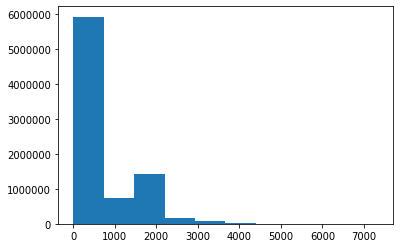

In [231]:
plt.hist(voxel_image.flatten())

In [ ]:
_plot_voxel(voxel_image[:, :, :])

In [ ]:
_plot_voxel(brain_voxel_mask)

In [ ]:
_plot_voxel(ventricles_voxel_mask)

### fin